In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors
import matplotlib.cm as cmx
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC 
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

from Notebook_helpers import load_data
from Notebook_helpers.modeling_helpers import *

%matplotlib inline

## Read in the data + Preprocess

In [33]:
df, train, val, test = load_data.load_coral_data(complete=True, CV=False, convert_to_categorical=True)

#### Prepare data with additional engineered features

In [34]:
# isolate the predictors and labels for both the training and test set
train_X, train_y, pred_names = load_data.get_features_and_response(train, with_feature_eng = True)
val_X, val_y, _ = load_data.get_features_and_response(val, with_feature_eng = True)

In [35]:
print("Features Used: " , pred_names.get_values())

Features Used:  ['Effluent' 'Sedimentation' 'New_Development' 'Habitat_Modification'
 'Invasive_Algae' 'Fishing_Comm_Total' 'Fishing_NonComm_Boat_Total'
 'Fishing_NonComm_Shore_Line' 'Fishing_NonComm_Shore_Net'
 'Fishing_NonComm_Shore_Spear' 'SST_CLIM_M' 'SST_STD' 'CHL_CLIM_M'
 'CHL_ANOM_F' 'PAR_CLIM_M' 'PAR_STD' 'WAV_CLIM_M' 'WAV_ANOM_F'
 'Complexity' 'Depth' 'sqrt_power_x_compexity' 'log_power_over_depth'
 'complexity_over_depth' 'Irradiance_x_inv_algae' 'both_anomolies']


##### Standardize the data

In [36]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(train_X.values)

# Apply transform to both the training set and the test set.
train_X = scaler.transform(train_X.values)
val_X = scaler.transform(val_X.values)

## Cross Validation to choose regularization strength

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, zero_one_loss
C = np.logspace(-4, 4, 15)
hyperparameters = dict(C=C)
clf = GridSearchCV(LogisticRegression(solver='newton-cg',
                                      multi_class='multinomial', 
                                      penalty='l2',
                                      random_state=1), 
                   hyperparameters, cv=5, verbose=0, iid=False,
                   scoring=make_scorer(metrics.f1_score, average='micro', greater_is_better=True),
                   return_train_score=True)
best_model = clf.fit(train_X, train_y)

# Best Model is the model picked with the optimal C retrained on the
# entire training data.

print('Best C:', best_model.best_estimator_.get_params()['C'])

Best C: 0.019306977288832496


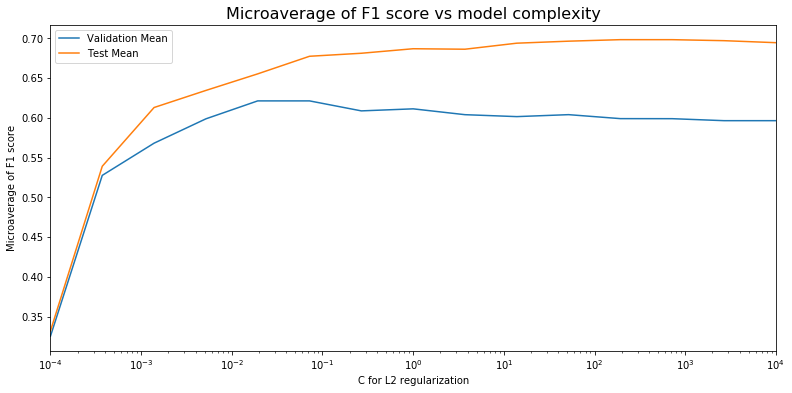

In [23]:
# from scikit-learn, "Demonstration of multi-metric evaluation on cross_val_score and GridSearchCV" 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
results = clf.cv_results_

plt.figure(figsize=(13, 6))
plt.title("Microaverage of F1 score vs model complexity",
          fontsize=16)

plt.xlabel("C for L2 regularization")
plt.ylabel("Microaverage of F1 score")

ax = plt.gca()
plt.xscale("log")
ax.set_xlim(C[0], C[-1])

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_C'].data, dtype=float)

sample_score_mean = results['mean_test_score']
# sample_score_std = results['std_test_score']

train_score_mean = results['mean_train_score']

# add error bars
plt.errorbar(x = X_axis, y = sample_score_mean, 
             label='Validation Mean', capsize=4, capthick=2)
plt.errorbar(x = X_axis, y = train_score_mean, 
             label='Test Mean', capsize=4, capthick=2)

plt.legend()

plt.grid(False)
plt.show()

## Confusion matrix for Cross Validated Regularization

Misclassified samples: 31
Classification Report:
              precision    recall  f1-score   support

           1       0.70      0.73      0.72        26
           2       0.77      0.82      0.79        28
           3       0.61      0.76      0.68        25
           5       0.67      0.38      0.48        21

    accuracy                           0.69       100
   macro avg       0.69      0.67      0.67       100
weighted avg       0.69      0.69      0.68       100



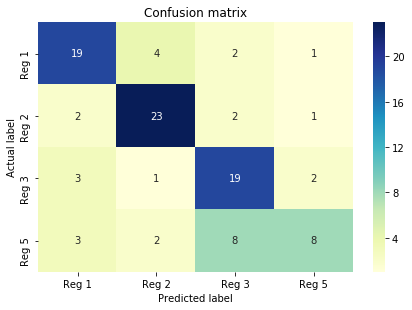

In [27]:
val_pred_multi = best_model.predict(val_X)
evaluate_performance(val_y, val_pred_multi, True)

## Error Analysis